In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
import pandas as pd

data = {
    'GDP': [
        21.43e12, 14.34e12, 2.87e12, 4.38e12, 5.08e12,
        1.57e12, 2.05e12, 0.35e12, 1.37e12, 1.22e12,
        3.56e12, 8.90e12, 6.73e12, 9.43e12, 2.45e12,
        1.13e12, 7.88e12, 0.79e12, 5.45e12, 0.99e12
    ],
    'Population': [
        331002651, 1439323776, 1380004385, 83783942, 126476461,
        145934462, 212559417, 59308690, 25499884, 128932753,
        113000000, 740000000, 850000000, 109000000, 675000000,
        455000000, 345000000, 123000000, 432000000, 111000000
    ],
    'EducationIndex': [
        99.0, 87.6, 74.0, 100.0, 99.4,
        99.0, 86.0, 73.0, 99.0, 90.0,
        80.0, 95.0, 85.0, 92.0, 88.0,
        70.0, 94.0, 60.0, 77.0, 65.0
    ],
    'LifeExpectancy': [
        79.5, 76.9, 69.4, 81.2, 84.6,
        72.8, 75.2, 64.1, 82.9, 75.4,
        78.0, 80.5, 70.3, 82.0, 73.5,
        65.8, 81.0, 60.4, 74.0, 66.7
    ]
}

spark = SparkSession.builder.appName("LifeExpectancyModel").getOrCreate()
spark_df = spark.createDataFrame(pd.DataFrame(data))

assembler = VectorAssembler(inputCols=["GDP", "Population", "EducationIndex"], outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol="LifeExpectancy", numTrees=100, seed=42)
pipeline = Pipeline(stages=[assembler, rf])

train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:442: UserWarning: check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning
  warnings.warn(


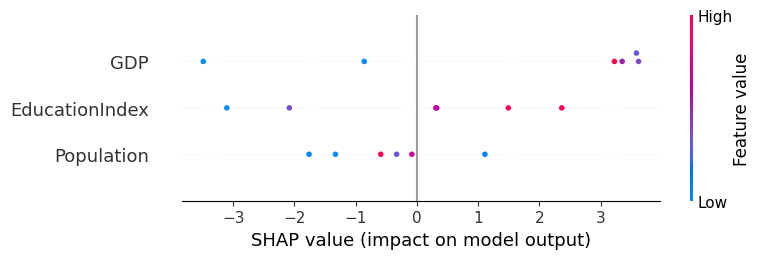

In [ ]:
import shap

trained_model = model.stages[-1]

explainer = shap.TreeExplainer(trained_model)

X_test_pd = test_df.select("GDP", "Population", "EducationIndex").toPandas()

shap_values = explainer.shap_values(X_test_pd)

shap.summary_plot(shap_values, X_test_pd)

## Feature ranking (y‑axis)
Features are ordered by their average absolute SHAP value (mean(|SHAP|)) across all countries. Top to bottom:  
1. **GDP** (most influential)  
2. **EducationIndex** (moderately influential)  
3. **Population** (least influential)  

## SHAP value (x‑axis)
Each point is one country’s SHAP value for that feature:  
- **Positive** (right of zero) → pushes the model’s life‑expectancy prediction **up**  
- **Negative** (left of zero) → pushes the prediction **down**  

## Color scale
- **Red** = high feature value  
- **Blue** = low feature value  

## Plot‑specific observations
- **GDP**  
  - Red points (high GDP) lie to the right → higher GDP increases predicted life expectancy  
  - Blue points (low GDP) lie to the left → lower GDP decreases it  
- **EducationIndex**  
  - Red points (high education) lie to the right → higher education index increases predicted life expectancy  
  - Blue points (low education) lie to the left → lower education index decreases it  
- **Population**  
  - Points cluster near zero → population size has only a minor effect  
  - Both red and blue points appear on either side of zero → no clear directional trend  

## Key takeaways
1. **GDP** is the strongest driver of life expectancy in this model.  
2. **EducationIndex** has a clear positive effect but is less influential than GDP.  
3. **Population** contributes very little, with mixed small positive and negative impacts.  


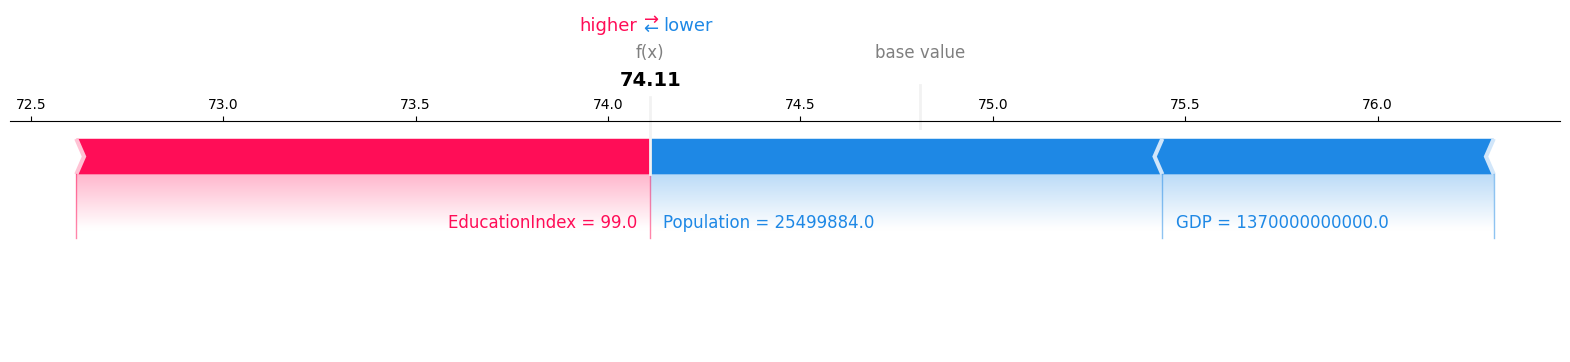

In [ ]:
# Visualize a single SHAP value for the first observation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_pd.iloc[0], matplotlib=True)

* **Arrow direction**  
  - → (right‑pointing) arrows are **positive** contributions (push prediction higher)  
  - ← (left‑pointing) arrows are **negative** contributions (push prediction lower)  

* **Arrow color**  
  - **Red** = high feature value  
  - **Blue** = low feature value  

* **Arrow length** = magnitude of each feature’s SHAP value

**In this plot:**

- **Base value** ≈ 75.0  
- **Predicted f(x)** = 74.11 (shown above the bar) ⇒ net negative shift of about –0.9  
- **EducationIndex = 99.0** (red, →) contributes **+1.6**  
- **Population = 25 499 884** (blue, ←) contributes **–1.3**  
- **GDP = 1.37 × 10¹²** (blue, ←) contributes **–0.4**  

The two negative contributions (Population + GDP) outweigh the positive one (EducationIndex), pulling the final prediction below the baseline.  
